<a href="https://colab.research.google.com/github/SunitKolabkar/Deep-Learning/blob/master/Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.collab import *
from fastai.tabular import *

In [0]:
from fastai.collab import *
from fastai.tabular import *

In [0]:
user, item, title = 'userId', 'movieId', 'title'

In [5]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [6]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0, 5.5]

In [0]:
learn = collab_learner(data,
                       n_factors=50,
                       y_range=y_range)

In [10]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.593714,0.909960,00:01
1,0.826972,0.675843,00:00
2,0.652406,0.671518,00:00


**Movielens 100K**

In [0]:
path = Config.data_path()/'ml-100k'

In [12]:
ratings = pd.read_csv('/u.data',
                      delimiter='\t',
                      header=None,
                      names=[user,item,'rating','timestamp'])

ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [13]:
movies = pd.read_csv('/u.item',
                     delimiter='|',
                     encoding='latin-1',
                     header=None,
                     names=[item,'title','date','N','url',
                            *[f'g{i}' for i in range(19)]])

movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [14]:
len(ratings)

100000

In [15]:
len(movies)

1682

In [16]:
rating_movie = ratings.merge(movies[[item,title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie,
                               seed=42,
                               valid_pct=0.1,
                               item_name=title)

In [18]:
data.show_batch()

userId,title,target
130,Billy Madison (1995),3.0
62,Tin Men (1987),4.0
851,Hoodlum (1997),4.0
684,"Nutty Professor, The (1996)",3.0
734,"Jungle Book, The (1994)",4.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data,
                       n_factors=40,
                       y_range=y_range,
                       wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


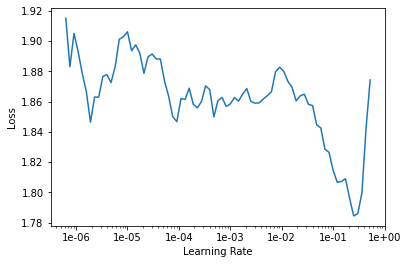

In [21]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [22]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.929141,0.935574,00:08
1,0.872992,0.884157,00:08
2,0.771321,0.831106,00:08
3,0.655582,0.806384,00:08
4,0.578255,0.808008,00:08


In [0]:
learn.save('dotprod')

## **Interpretation**

**Setup**

In [24]:
learn.load('dotprod')

CollabLearner(data=TabularDataBunch;

Train: LabelList (90000 items)
x: CollabList
userId 196; title Kolya (1996); ,userId 63; title Kolya (1996); ,userId 226; title Kolya (1996); ,userId 154; title Kolya (1996); ,userId 306; title Kolya (1996); 
y: FloatList
3.0,3.0,5.0,3.0,5.0
Path: .;

Valid: LabelList (10000 items)
x: CollabList
userId 498; title Casino (1995); ,userId 642; title Pocahontas (1995); ,userId 58; title 2001: A Space Odyssey (1968); ,userId 495; title Cat People (1982); ,userId 618; title Philadelphia (1993); 
y: FloatList
3.0,5.0,4.0,3.0,3.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.1, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<clas

In [25]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [26]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

**Movie Bias**

In [27]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i, b in zip(top_movies, movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [30]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3657),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.2975),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2713), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2692), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2487), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2403), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2345), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2343), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2309), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2281), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2259), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2233), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2168), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2138), "Stephen King's The Langoliers (1995)", 2.413793103448276),
 (tensor(-0.2131)

In [31]:
sorted(movie_ratings, key=lambda o:o[0], reverse=True)[:15]

[(tensor(0.5826), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5786), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5549), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5475), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5307), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5167), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5162), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5121), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4924), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4899), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4847), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4778), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4707), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4635), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4603), 'Usual Suspects, The (1995)', 4.385767790262173)]

**Movie Weights**

In [32]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [33]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0, fac1, fac2 = movie_pca.t()
movie_comp = [(f,i) for f,i in zip(fac0, top_movies)]

In [35]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1141), 'Wrong Trousers, The (1993)'),
 (tensor(1.0837), 'Chinatown (1974)'),
 (tensor(1.0685), 'Close Shave, A (1995)'),
 (tensor(0.9765), '12 Angry Men (1957)'),
 (tensor(0.9749), 'When We Were Kings (1996)'),
 (tensor(0.9717), 'Casablanca (1942)'),
 (tensor(0.9617), 'Ran (1985)'),
 (tensor(0.9606), 'Persuasion (1995)'),
 (tensor(0.9552), 'Godfather, The (1972)'),
 (tensor(0.9536), 'Secrets & Lies (1996)')]

In [36]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2644), 'Home Alone 3 (1997)'),
 (tensor(-1.1909), 'Jungle2Jungle (1997)'),
 (tensor(-1.1806), "McHale's Navy (1997)"),
 (tensor(-1.1571), 'Congo (1995)'),
 (tensor(-1.1271), 'Leave It to Beaver (1997)'),
 (tensor(-1.0951), 'Batman & Robin (1997)'),
 (tensor(-1.0831), 'Bio-Dome (1996)'),
 (tensor(-1.0623), 'Flipper (1996)'),
 (tensor(-1.0481), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.0434), 'Children of the Corn: The Gathering (1996)')]

<function matplotlib.pyplot.show>

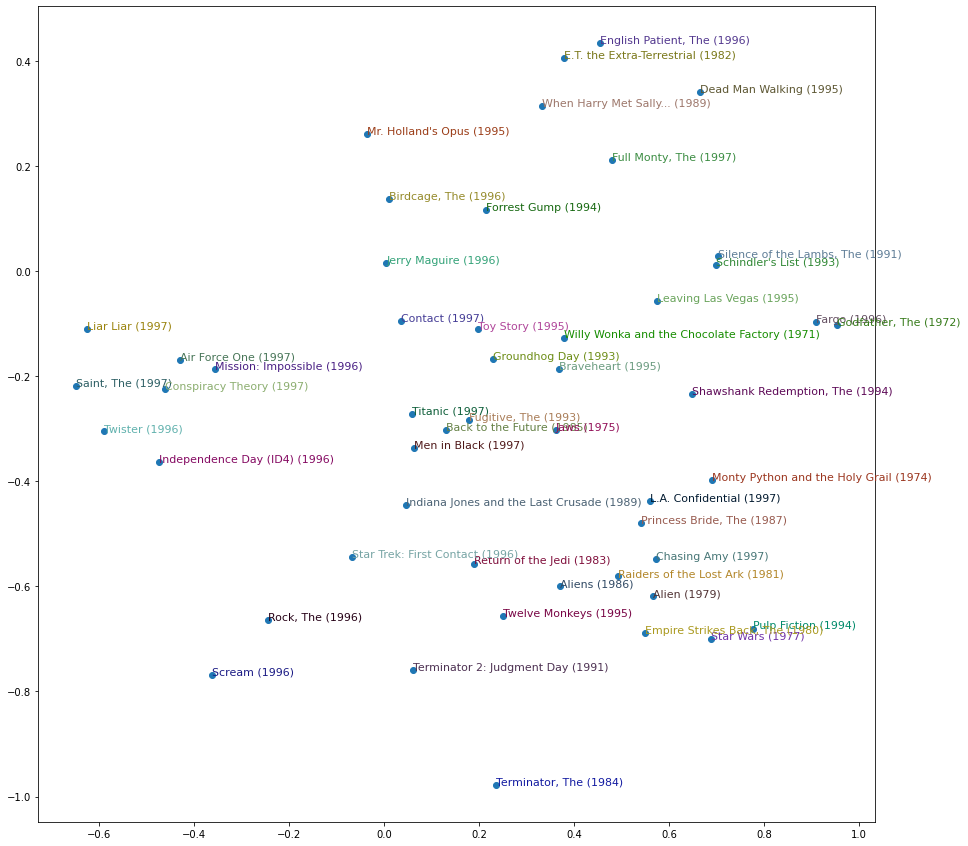

In [37]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
  plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show